In [1]:
import joblib
import sys
import os
from os.path import abspath
import numpy as np
from sklearn.preprocessing import StandardScaler
import h5py
if abspath('../../utils/') not in sys.path:
    sys.path.append(abspath('../../utils/'))
from utils import GetExtent, ventana

features = ['dem', 'vegh', 'slope', 'aspect', 'curvature']

In [2]:
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Convolution2D, Activation
from keras import losses
from sklearn.preprocessing import StandardScaler
import gc
%matplotlib inline

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
datos = joblib.load('../../processed/subset_datos.joblib')

### Print the Shapes of the arrays found in the dictionary.

In [ ]:
for llave, d in datos.items():
    print(llave, datos[llave].shape)

## Generate the X and Y for Keras

In [5]:
X = np.stack([d for llave, d in datos.items() if llave != 'snowdepth'], axis=-1)
Y = np.expand_dims(datos['snowdepth'], axis=-1)

In [6]:
print(X.shape)
print(Y.shape)

(4000, 4000, 5)
(4000, 4000, 1)


In [7]:
kernal = (100, 100)
stride = (100, 100)
XX = ventana(signal=X, kernel_size=kernal, stride=stride)
YY = ventana(signal=Y, kernel_size=kernal, stride=stride)

In [8]:
XX = np.stack(XX, axis=0)
YY = np.stack(YY, axis=0)

In [9]:
XX.shape

(1600, 100, 100, 5)

### Create Training and Testing Sets

In [10]:
Xout = {}
Yout = {}
# UTMEout = {}
# UTMNout = {}
ixs = {}
train_per = .20
# Permuter ---------------------------
train_size = np.int(np.ceil(train_per * XX.shape[0]))
permutation = np.random.permutation(XX.shape[0])
ixs['train'] = np.sort(permutation[:train_size])
ixs['test'] = np.sort(permutation[train_size:])

# Trainset ------------------------
Xout['train'] = XX[ixs['train'], :, :, :]
Yout['train'] = YY[ixs['train'], :, :, :]
# UTMEout['train'] = UTME[ixs['train'], :, :, :]
# UTMNout['train'] = UTMN[ixs['train'], :, :, :]

# Testset -------------------------
Xout['test'] = XX[ixs['test'], :, :, :]
Yout['test'] = YY[ixs['test'], :, :, :]

# UTMEout['test'] = UTME[ixs['test'], :, :, :]
# UTMNout['test'] = UTMN[ixs['test'], :, :, :]

# Scale ------------------
scaler = StandardScaler()
Xtr_tmp = scaler.fit_transform(Xout['train'].reshape(-1, XX.shape[-1]))
Xout['train'] = Xtr_tmp.reshape(Xout['train'].shape)
Xte_tmp = scaler.transform(Xout['test'].reshape(-1, XX.shape[-1]))
Xout['test'] = Xte_tmp.reshape(Xout['test'].shape)

In [11]:
print('Xtrain:', Xout['train'].shape)
print('Ytrain:', Yout['train'].shape)
print('---')
print('Xtest:', Xout['test'].shape)
print('Ytest:', Yout['test'].shape)

Xtrain: (320, 100, 100, 5)
Ytrain: (320, 100, 100, 1)
---
Xtest: (1280, 100, 100, 5)
Ytest: (1280, 100, 100, 1)


In [12]:
# with h5py.File("../../processed/train_test.hdf5", 'w') as f:
#     f.create_dataset('Xtrain', data=Xout['train'])
#     f.create_dataset('Xtest', data=Xout['test'])
#     f.create_dataset('Ytrain', data=Yout['train'])
#     f.create_dataset('Ytest', data=Yout['test'])
#     f.create_dataset('ixs_test', data=ixs['test'])
#     f.create_dataset('ixs_train', data=ixs['train'])

#### Define Model Architecture

In [18]:
def base_model(input_dim):
    model = Sequential()
    model.add(Convolution2D(
        filters=50,
        kernel_size=(40,40),
        strides=(1,1),
        padding='same',
        input_shape=input_dim)
    )
    model.add(Activation('relu'))    
    model.add(Convolution2D(
        filters=60,
        kernel_size=(30,30),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=70,
        kernel_size=(20,20),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=80,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    # ---------------------------------------- #
    #            Compile Model                 #
    # ---------------------------------------- #
    model.compile(loss=losses.mean_squared_error,
                  optimizer=Adam(lr=0.0001),
                  metrics=['mse'])
    return model


In [19]:
# ---------------------------------------- #
#         Call and Fit Model               #
# ---------------------------------------- #
# simple early stopping
es = EarlyStopping(monitor='val_mse',
                   mode='min',
                   verbose=1,
                   patience=100)

model_save = ModelCheckpoint(os.path.join('../../', 'models', 'best_model.h5'),
                             monitor='val_mse',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

In [20]:
model = base_model(
    Xout['train'].shape[1:]
)

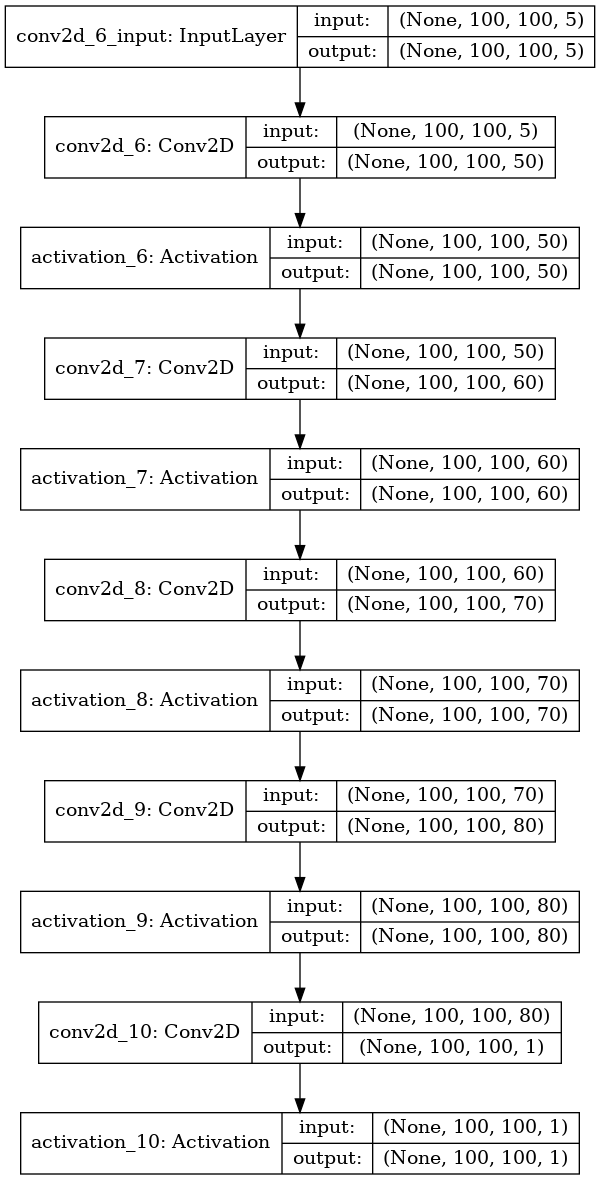

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='../../models/model.png', show_shapes=True)

In [ ]:
hist = model.fit(
    Xout['train'], Yout['train'],
    epochs=50,
    validation_data=(Xout['test'], Yout['test']),
    batch_size=10,
    verbose=1,
    shuffle=True,
    callbacks=[es, model_save]
)
print('\n\n')
print('-----------------')
print('-----------------')

Train on 320 samples, validate on 1280 samples
Epoch 1/50
170/320 [==============>...............] - ETA: 28:10 - loss: 0.5200 - mean_squared_error: 0.5200

In [ ]:
# ------------------ #
# Save Model Weights #
# ------------------ #

'model.save_weights('../../models/model_weights.h5')
# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())